In [2]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
import itertools
import shutil

In [ ]:
"""
This code takes a .sgy file exported from SeisWare with the 
StandardSEGY_Rev1.kwd file and creates a new .sgy file
that is crossline sorted and has additional binary and
trace headers filled in for easier loading into seismic
interpretation software.

Notes for Petrel:
 - Load data using "SEG-Y seismic data", do NOT use the option
   to load with preset parameters
   
Notes for OpendTect:
 - Data should load using default parameters

"""

In [ ]:
## Define filepaths
## src is the .sgy exported from SeisWare
## dst is the new .sgy file, and will be created in this code

filepath_src = './Rev1_Cropped.sgy'
filepath_dst = './Rev1_Cropped_Edited.sgy'

shutil.copyfile(filepath_src, filepath_dst)

In [13]:
## Overwrite the dst file, resorted from fast-crossline
## to fast-inline. Write some extra binary headers


with segyio.open(filepath_src) as src:
    with segyio.open(filepath_dst, 'r+') as dst:
        
        assert (src.header[0][segyio.TraceField.INLINE_3D] - src.header[1][segyio.TraceField.INLINE_3D]) != 0, \
        "File already properly sorted"
        
        inlines = range(len(src.ilines))
        xlines = range(len(src.xlines))
        ntraces = len(src.trace)
        num_inlines = len(src.ilines)
        num_xlines = len(src.xlines)
    
        grid = itertools.product(inlines, xlines)
        
        for out, (i,j) in zip (range(ntraces), grid):
            dst.header[out] = src.header[ j * num_inlines + i]
            dst.trace[out] = src.trace[ j * num_inlines + i]
            
        dst.bin[segyio.BinField.SortingCode] = 1
        dst.bin[segyio.BinField.SEGYRevision] = 1
        dst.bin[segyio.BinField.Traces] = 1
            
        for i in range(len(dst.trace)):
            xline_idx = np.where(dst.xlines == dst.header[i][segyio.TraceField.CROSSLINE_3D])[0]
            xline_idx = int(xline_idx) + 1

            dst.header[i][segyio.TraceField.TRACE_SEQUENCE_LINE] = xline_idx
            dst.header[i][segyio.TraceField.TRACE_SEQUENCE_FILE] = dst.header[i][segyio.TraceField.INLINE_3D]
            dst.header[i][segyio.TraceField.FieldRecord] = dst.header[i][segyio.TraceField.INLINE_3D]
            dst.header[i][segyio.TraceField.TraceNumber] = xline_idx
            dst.header[i][segyio.TraceField.CDP] = dst.header[i][segyio.TraceField.CROSSLINE_3D]
            dst.header[i][segyio.TraceField.CDP_X] = dst.header[i][segyio.TraceField.GroupX]
            dst.header[i][segyio.TraceField.CDP_Y] = dst.header[i][segyio.TraceField.GroupY]

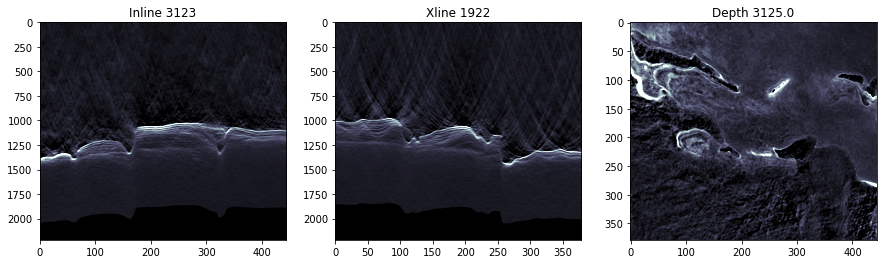

In [14]:
## Visual QC of the new edited file

with segyio.open(filepath_dst) as segyfile:
    
    crossline_display_index = 200
    inline_display_index = 200
    depth_display_index = 1250
    
    xl_num = segyfile.xlines[crossline_display_index]
    xline_arr = segyfile.xline[xl_num]
    
    il_num = segyfile.ilines[inline_display_index]
    iline_arr = segyfile.iline[il_num]
    
    depth_slice = segyfile.depth_slice[depth_display_index]
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
ax[0].imshow(iline_arr.T, cmap='bone', vmin=0, vmax=0.04, aspect='auto')
ax[1].imshow(xline_arr.T, cmap='bone', vmin=0, vmax=0.04, aspect='auto')
ax[2].imshow(depth_slice, cmap='bone', vmin=0, vmax=0.04, aspect='auto')

ax[0].set_title("Inline {}".format(il_num))
ax[1].set_title("Xline {}".format(xl_num))
ax[2].set_title("Depth {}".format(segyfile.samples[1250]))

plt.show()

In [15]:
## QC the binary and trace headers in the new file

filepath = './Rev1_Cropped_Edited.sgy'

with segyio.open(filepath_dst) as segyfile:
    
    print("Binary Header:")
    print(segyfile.bin)
    
    print("\nTrace Headers for first and last trace")
    for i in segyfile.header[0].keys():
        print(i, ": ", segyfile.header[0][i], "\t", segyfile.header[-1][i])
        

Binary Header:
{JobID: 0, LineNumber: 0, ReelNumber: 0, Traces: 1, AuxTraces: 0, Interval: 2500, IntervalOriginal: 0, Samples: 2217, SamplesOriginal: 0, Format: 1, EnsembleFold: 0, SortingCode: 2, VerticalSum: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 0, MeasurementSystem: 0, ImpulseSignalPolarity: 0, VibratoryPolarity: 0, ExtAuxTraces: 0, ExtSamples: 0, ExtSamplesOriginal: 0, ExtEnsembleFold: 0, SEGYRevision: 1, SEGYRevisionMinor: 0, TraceFlag: 0, ExtendedHeaders: 0}

Trace Headers for first and last trace
TRACE_SEQUENCE_LINE :  1 	 444
TRACE_SEQUENCE_FILE :  2923 	 3301
FieldRecord :  2923 	 3301
TraceNumber :  1 	 444
EnergySourcePoint :  0 	 0
CDP :  1722 	 2165
CDP_TRACE :  0 	 0
TraceIdentificationCode :  0 	 0
NSummedTraces :  0 	 0
NStackedTraces :  0 	 0
DataUse :  0 	 0
offset :  0 	 0
ReceiverGroupElevation :  0 	 0
